<a href="https://colab.research.google.com/github/realtommypoole/AAI-511-Team-7-Compo-Identi/blob/tommy-AAI-511/final_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ID The Composer Algorithm
##A Deep Learning Neural Network for Composer Identification

###Overview & Goals
This code is designed to ingest music files to train deep learning models in order to identify the composer based on the music alone. The primary objective is to develp a deep learnign model that can predict the composer of a given musical score accurately.

The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

This project is part of the Master's In Applied Artificial Intelligence program at the University of San Diego.

###Methodology for this Project
1. Data Collection (data provided)
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.




##Data Pre-Processing

In [1]:
!pip install pretty_midi
#!pip install kagglehub

In [2]:
# Import Key Libraries
import os
import zipfile
from zipfile import ZipFile
import warnings
import pretty_midi
import numpy as np
import pandas as pd
import mido
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import pretty_midi as pm
import kagglehub as kagglehub # Wire to kaggle?
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
'''
#Confirm we can connecct to GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
'''
#path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
#print("Path to dataset files:", path)

In [ ]:
# Connect to dataset in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define filepaths
##Module 2 Data
#zip_path = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset.zip'
#extract_base_dir = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data'
##Code to extract zip file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_base_dir)

#Module 7 Data
zip_path = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive.zip'
extract_base_dir = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2'

def extract_all_zips(base_dir):
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith('.zip'):
                nested_zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(nested_zip_path)[0]
                with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                # Recursively extract ZIPs within the new extraction directory
                extract_all_zips(extract_path)

# First, extract the main zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_dir)

# Then, recursively extract all nested ZIP files in the extracted base dir
extract_all_zips(extract_base_dir)

In [3]:
base_dir = "/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2"
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Store results
matched_paths = []

for root, dirs, files in os.walk(base_dir):
    for f in files:
        file_path = os.path.join(root, f)
        # Check if any composer is in the file path
        if any(composer.lower() in file_path.lower() for composer in composers):
            matched_paths.append(file_path)

# Create DataFrame
df = pd.DataFrame(matched_paths, columns=['filepath'])
pd.set_option('display.max_colwidth', None)  # Show columns as wide as needed
print(df)

                                                                                                                                   filepath
0                      /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Liszt Bach Prelude Transcription.mid
1                                /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/C.P.E.Bach Solfeggieto.mid
2                                         /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/AveMaria.mid
3                        /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0529 Sonate en trio n5.mid
4                        /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0531 Prelude and Fugue.mid
...                                                                                                                                     ...
3343   /content/driv

In [4]:
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
supported_ext = ('.mid', '.midi')

def find_composer(filepath, composers):
    filepath = filepath.lower()
    for composer in composers:
        if composer.lower() in filepath:
            return composer
    return None

# Keep only MIDI files
df = df[df['filepath'].str.lower().str.endswith(supported_ext)].copy()

# Assign composer
df['composer'] = df['filepath'].apply(lambda x: find_composer(x, composers))

# Drop any rows where composer is not found
df = df.dropna(subset=['composer'])

# Collect filepaths for each composer (as a dict or separate DataFrames, as you prefer)
composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

# Example: see how many files per composer
for composer, files in composer_files.items():
    print(f"{composer}: {len(files)} files")

Bach: 2100 files
Beethoven: 440 files
Chopin: 276 files
Mozart: 518 files


In [5]:
df.head()

,filepath,composer
0,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Liszt Bach Prelude Transcription.mid,Bach
1,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/C.P.E.Bach Solfeggieto.mid,Bach
2,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/AveMaria.mid,Bach
3,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0529 Sonate en trio n5.mid,Bach
4,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0531 Prelude and Fugue.mid,Bach


#Data Pre-Processing & Feature Extraction

In [6]:
#Code to reset df
df_1 = df.copy()

In [31]:
df = df_1.copy()

In [32]:
#Try to maintain as much data as possible, but balance datasets
# List composer names for safety
bach_name = 'Bach'

df_bach     = df[df['composer'] == bach_name].sample(frac=0.5, random_state=1)
df_others   = df[df['composer'] != bach_name].groupby('composer', group_keys=False).sample(frac=0.93, random_state=1)

# Combine and shuffle (optional)
df_sampled = pd.concat([df_bach, df_others]).reset_index(drop=True)
df_sampled = df_sampled.sample(frac=1.0, random_state=1).reset_index(drop=True)  # optional: shuffle

df = df_sampled

# Confirm total number of filepaths
print(len(df))

2198


In [ ]:
#Sanatize MIDI files
def sanitize_midi(input_path, output_path=None):
    try:
        mid = mido.MidiFile(input_path)
        global_events = []
        new_tracks = [mido.MidiTrack()]
        for i, track in enumerate(mid.tracks):
            new_track = mido.MidiTrack()
            for msg in track:
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    if i != 0:  # Only move if not already in track 0
                        global_events.append(msg)
                    else:
                        new_track.append(msg)
                else:
                    new_track.append(msg)
            if i != 0:
                new_tracks.append(new_track)
        new_tracks[0].extend(global_events)
        mid.tracks = new_tracks
        output = output_path or input_path
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")

In [ ]:
successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  # Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      # Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

# NOW you can filter df after the loop, using failed_paths if/as needed:
# EITHER: Keep only success
df_success = df[df['filepath'].isin(successful_paths)].reset_index(drop=True)

# OR: Remove failures from your original df
df_no_failed = df[~df['filepath'].isin(failed_paths)].reset_index(drop=True)

Sanitizing MIDI files:  39%|███▉      | 428/1100 [00:56<01:58,  5.69it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  42%|████▏     | 459/1100 [01:03<02:35,  4.12it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  57%|█████▋    | 623/1100 [01:29<00:25, 18.57it/s]

[ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  74%|███████▎  | 809/1100 [01:44<00:19, 15.16it/s]

[ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  80%|████████  | 882/1100 [01:54<00:22,  9.75it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files: 100%|██████████| 1100/1100 [02:29<00:00,  7.38it/s]


In [ ]:
# Confirm errors were filtered from df
print(len(df))

3334


In [9]:
# Define function to extract statistical features from MIDI files
def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }

In [10]:
# Define function to compute sequential features from MIDI files
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }

In [11]:
# Execute defined feature extraction function on MIDI files list for features
feature_collection = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    midi_file = row['filepath']
    composer_label = row['composer']
    try:
        stat_features = compute_statistical_midi_features(midi_file)
        seq_features = compute_sequence_midi_features(midi_file)
        combined = {**stat_features, **seq_features,
                    "composer": composer_label,
                    "file": midi_file}
        feature_collection.append(combined)
    except Exception as e:
        print(f"[ERROR] Failed to process {midi_file}: {e}")

features_df = pd.DataFrame(feature_collection)

Extracting features:  16%|█▋        | 330/2001 [01:02<03:04,  9.08it/s]/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting features:  71%|███████   | 1413/2001 [07:01<05:02,  1.94it/s]

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Extracting features:  72%|███████▏  | 1442/2001 [07:50<22:43,  2.44s/it]

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Extracting features:  80%|███████▉  | 1597/2001 [09:46<00:45,  8.86it/s]

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


Extracting features:  87%|████████▋ | 1746/2001 [10:43<01:10,  3.64it/s]

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Extracting features: 100%|██████████| 2001/2001 [13:14<00:00,  2.52it/s]


In [12]:
def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

In [13]:
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'note_seq', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'composer', 'file'],
      dtype='object')


Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1997.000000       1997.000000   1997.000000   1967.000000   
mean       227.672678          5.170756   3022.802203     11.470511   
std        286.699735          4.525411   4685.952444      7.440368   
min          0.000000          0.000000      0.000000      2.126582   
25%         45.000000          2.000000    333.000000      6.791191   
50%        112.002083          4.000000   1121.000000      8.722222   
75%        280.250000          5.000000   3601.000000     13.250894   
max       4482.375000         40.000000  46897.000000     55.335065   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1967.000000  1967.000000  1967.000000  1967.000000   1967.000000   
mean       83.436968    35.426029    84.204372    62.986884     64.865785   
std        18.467564     6.472297     7.107582     3.061565      6.513331   
min        30.812865     9.000000

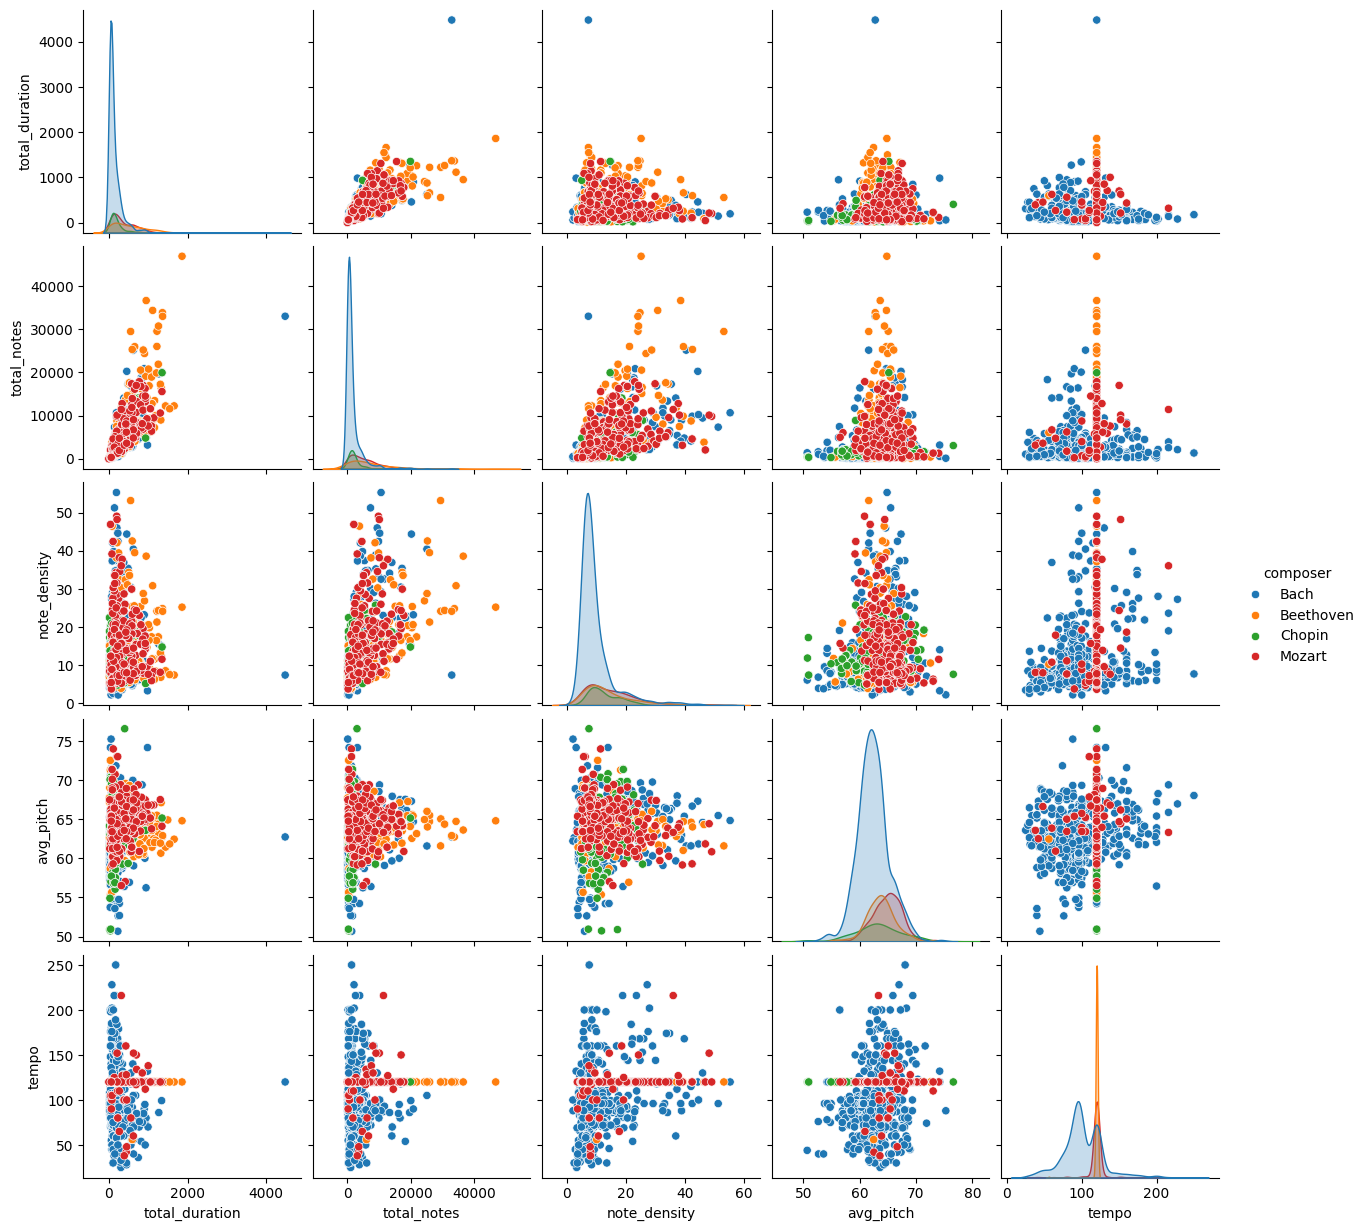

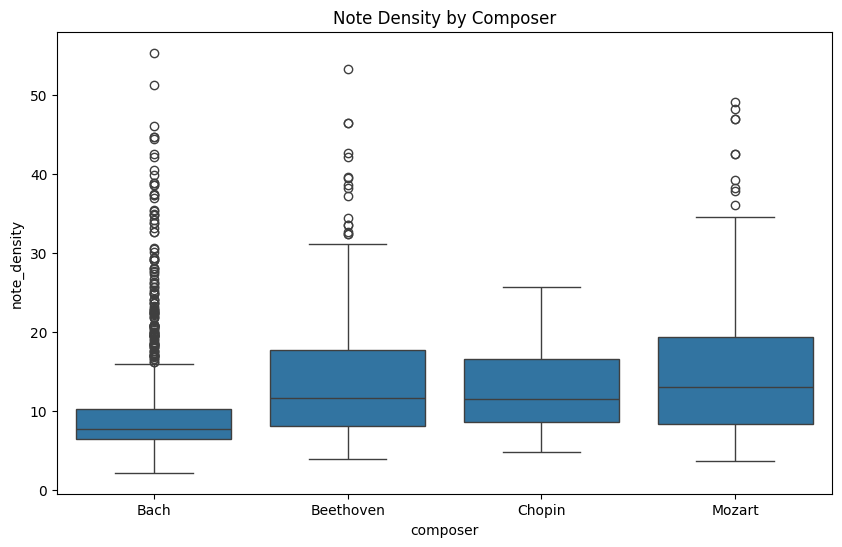

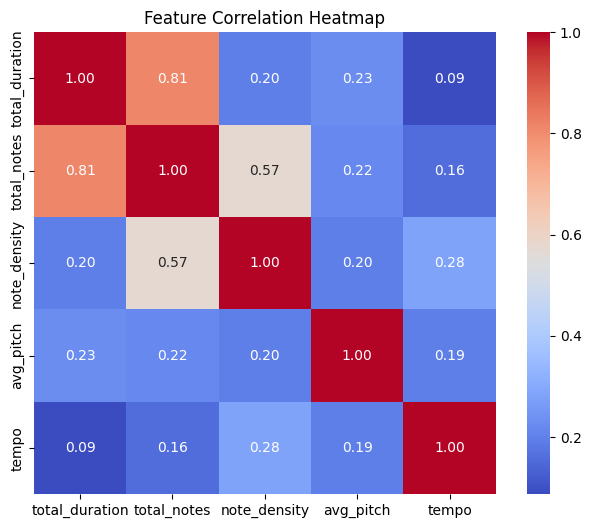

In [14]:
run_exploratory_data_analysis(features_df)

Number of valid sequences: 1967
Mean sequence length (number of notes): 3068.904931367565
Min sequence length: 83
Max sequence length: 46897


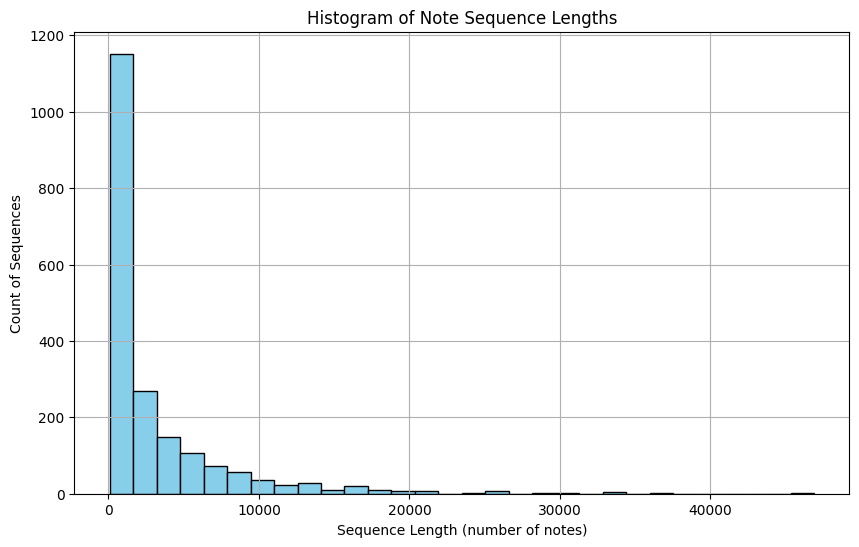

In [15]:
# Extract note sequences
note_seqs = features_df['note_seq']

# Keep only valid sequences (numpy arrays with shape (N, 4))
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

# Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

# Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

In [16]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(features_df, test_size=0.3, random_state=42)

In [17]:
#What is the counts of data in each folder, train, test, validation?
print(train_df.shape)
print(test_df.shape)

(1397, 23)
(600, 23)


In [18]:
def normalize_note_seq(seq, min_pitch=21, max_pitch=108, max_velocity=127, max_duration=10.0):
    try:
        if not isinstance(seq, np.ndarray):
            seq = np.array(seq)
        if seq.ndim != 2 or seq.shape[1] < 4:
            # Skip or return original, or you could return np.zeros(...) or np.nan
            return seq
        seq = seq.astype(float)
        # Pitch (column 1)
        seq[:, 1] = (seq[:, 1] - min_pitch) / (max_pitch - min_pitch)
        seq[:, 1] = np.clip(seq[:, 1], 0, 1)
        # Velocity (column 3)
        seq[:, 3] = seq[:, 3] / max_velocity
        seq[:, 3] = np.clip(seq[:, 3], 0, 1)
        # Duration (column 2)
        seq[:, 2] = seq[:, 2] / max_duration
        seq[:, 2] = np.clip(seq[:, 2], 0, 1)
        return seq
    except Exception as e:
        # Optional: print(f"Skipping bad sequence: {e}")
        return seq


#Model Building

###LSTM

In [19]:
def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    X_seq_data = [] # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    y_labels_seq = [] # Initialize a list to store label indices corresponding to composers.

    composer_idx_mapping = {name: idx for idx, name in enumerate(composers)} # Create a mapping of composer names to numeric indices for classification.

    for index, row in input_df.iterrows(): # Iterate over each MIDI file (row) in the input dataframe.

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]      # shape (n_notes, 3)
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  # shape (2,)
        composer_label = row['composer']

        # Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  # shape (n_notes, 2)

        # Concatenate along the last axis (columns) -> shape (n_notes, 5)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  # 4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if full_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = full_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[composer_label])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 6 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(composers))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot

In [20]:

def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # LSTM layers are designed to learn temporal patterns in sequence data.
    # Here, it learns how note sequences vary across different composers.
    lstm_net.add(layers.LSTM (64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.


    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    lstm_net.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',   #
      metrics=['accuracy']
    )

    # Return the constructed LSTM classifier model.
    return lstm_net

###CNN

In [ ]:
def create_cnn_ready_data(input_df, piano_roll_column='piano_roll', max_length=5000):
    """
    Converts piano roll matrices into CNN-ready image tensors.

    Piano rolls are treated as 2D images where height = 128 MIDI pitches and width = time steps.
    This function formats the data for CNN input by resizing, padding, and adding a channel dimension.
    """

    # Initialize a list to hold the CNN input images (piano rolls as tensors).
    X_cnn_inputs = []

    # Initialize a list to hold the corresponding composer labels as class indices.
    y_cnn_labels = []

    # Create a mapping of composer names to numeric indices.
    # Example: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}
    composer_mapping = {name: idx for idx, name in enumerate(COMPOSERS)}

    # Iterate over each row in the input dataframe.
    for _, row in input_df.iterrows():

        # Extract the piano roll matrix from the specified column.
        # Shape: (128, time_steps)
        piano_roll = row[piano_roll_column]

        # Pad the piano roll if it has fewer time steps than max_length.
        # Padding ensures all inputs have the same width (time dimension).
        if piano_roll.shape[1] < max_length:
            piano_roll_padded = np.pad(piano_roll, ((0, 0), (0, max_length - piano_roll.shape[1])))
        else:
            # If the piano roll is longer, truncate it to max_length time steps.
            piano_roll_padded = piano_roll[:, :max_length]

        # Add a channel dimension to match CNN input format: (128, max_length, 1).
        # This makes the piano roll a grayscale "image" for the CNN.
        X_cnn_inputs.append(piano_roll_padded[..., np.newaxis])

        # Append the corresponding composer label as a numeric index.
        y_cnn_labels.append(composer_mapping[row['composer_label']])

    # Convert the input list to a NumPy array for CNN training.
    # - Cast to float32 for compatibility with TensorFlow.
    # - Shape: (num_samples, 128, max_length, 1)
    X_cnn_inputs = np.array(X_cnn_inputs).astype(np.float32)

    # One-hot encode the labels for multi-class classification.
    # Shape: (num_samples, num_classes)
    y_cnn_labels = to_categorical(y_cnn_labels, num_classes=len(COMPOSERS))

    # Return the CNN-ready inputs and labels.
    return X_cnn_inputs, y_cnn_labels

In [ ]:
def build_simple_cnn_for_pianoroll(cnn_input_shape, num_output_classes):
    """
    Builds and returns a simple Convolutional Neural Network (CNN) classifier for piano roll data.

    This model is used to classify composers based on piano roll "image" features extracted from MIDI files.
    CNNs are well-suited for this task because piano rolls are structured as 2D matrices (128 pitches × time frames),
    making them similar to grayscale images where convolutional layers excel.
    """

    # Initialize a Sequential model from Keras.
    # Sequential models are easy to build layer-by-layer when the architecture is straightforward.
    cnn_net = models.Sequential()

    # Add the first 2D convolutional layer:
    # - 32 filters (feature maps) to detect local pitch-time patterns.
    # - Kernel size of (3,3) allows the network to scan small note-time regions.
    # - Activation function: ReLU (introduces non-linearity).
    # - Input shape: (128, sequence_length, 1) where sequence_length is typically 5000.
    cnn_net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=cnn_input_shape))

    # Add max pooling layer:
    # - Reduces the spatial dimensions by taking the max value in a (2x2) window.
    # - Helps downsample the input while retaining important features.
    # - Reduces computation and prevents overfitting.
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Add a second 2D convolutional layer:
    # - 64 filters to capture more complex and abstract musical patterns.
    # - Larger depth allows the network to learn richer representations.
    cnn_net.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Add another max pooling layer:
    # - Further reduces spatial size to make the model more efficient.
    # - Also helps extract hierarchical features (small patterns → larger patterns).
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Flatten the multi-dimensional output of the convolutional layers.
    # - Converts 2D feature maps into a 1D vector to feed into fully connected layers.
    cnn_net.add(layers.Flatten())

    # Add a dense (fully connected) hidden layer:
    # - 128 neurons to combine features learned by the CNN layers.
    # - ReLU activation helps capture non-linear relationships between features.
    cnn_net.add(layers.Dense(128, activation='relu'))

    # Add the final output layer:
    # - Number of neurons equals the number of output classes (e.g., 4 composers).
    # - Softmax activation produces probabilities for multi-class classification.
    cnn_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the CNN model:
    # - Optimizer: Adam (adaptive learning rate, efficient for deep learning tasks).
    # - Loss function: Categorical cross-entropy (for multi-class classification with one-hot labels).
    # - Metric: Accuracy (to track performance during training and validation).
    cnn_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the constructed CNN model.
    return cnn_net

##Model Training & Evaluation

In [21]:
# -----------------------------
# LSTM Model (Sequence Model)
# -----------------------------
print(" Preparing LSTM data...")

# Filter out rows with unexpected note_seq shapes before creating sequences
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()


# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_df_filtered, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_df_filtered, target_length=500)

print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(composers))

# Define early stopping callback: monitors val_loss, stops if no improvement after e.g., 8 epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=20,              # number of epochs with no improvement
    restore_best_weights=True # restores weights from best epoch
)

# Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]    # Pass the callback here
)

 Preparing LSTM data...
 Training LSTM model...
Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.6134 - loss: 1.1762 - val_accuracy: 0.6145 - val_loss: 0.9598
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6756 - loss: 0.7866 - val_accuracy: 0.6509 - val_loss: 0.9017
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.6899 - loss: 0.7488 - val_accuracy: 0.6473 - val_loss: 0.8950
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.7057 - loss: 0.7391 - val_accuracy: 0.6655 - val_loss: 0.8460
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.7337 - loss: 0.6910 - val_accuracy: 0.6582 - val_loss: 0.8412
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.7341 - loss: 0.6910 - val_accuracy: 0.6364 - val_loss: 0.8620
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.7346 - loss: 0.6654 - val_accuracy: 0.6764 - val_loss: 0.8159
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/

In [22]:
# Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7717 - loss: 0.6851

Test Loss: 0.6710
Test Accuracy: 0.7798


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
              precision    recall  f1-score   support

        bach       0.91      0.92      0.91       368
      handel       0.57      0.53      0.55        86
      chopin       0.62      0.46      0.53        54
      mozart       0.53      0.63      0.58        87

    accuracy                           0.78       595
   macro avg       0.66      0.64      0.64       595
weighted avg       0.78      0.78      0.78       595



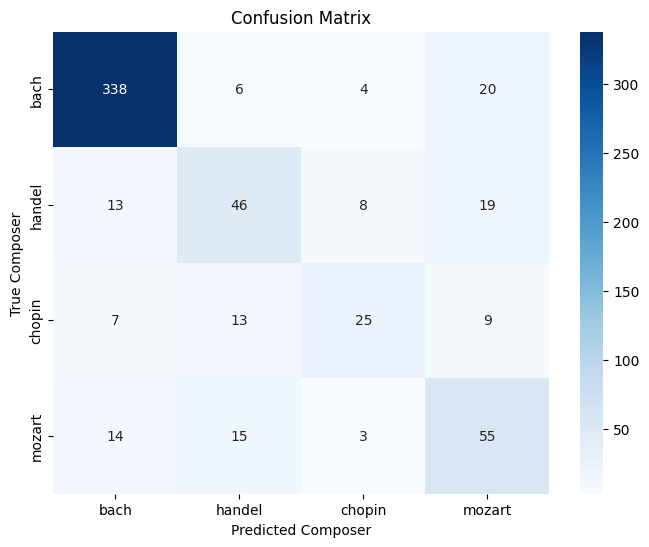

In [23]:
# Composer names/classes, in label order
class_names = ['bach', 'handel', 'chopin', 'mozart']  # Adapt as needed

# Evaluate the model and predict classes
# y_test: true labels (one-hot encoded or integer-encoded)
# model: your trained LSTM

# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=class_names))

# Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# -----------------------------
#  CNN on Piano Roll
# -----------------------------
print(" Preparing CNN data from piano rolls...")

# Prepares CNN input data by converting piano roll matrices to (128, sequence_length, 1).
# Each piano roll is treated as a grayscale image for CNN learning.
X_train_cnn, y_train_cnn = create_cnn_ready_data(train_features, max_length=5000)
X_test_cnn, y_test_cnn = create_cnn_ready_data(test_features, max_length=5000)

print(" Training CNN on Piano Roll...")

# Define CNN input shape: (128, sequence_length, 1)
cnn_input_shape = X_train_cnn.shape[1:]

# Build CNN model to classify composer from piano roll images.
cnn_model_final = build_simple_cnn_for_pianoroll(cnn_input_shape, num_output_classes=len(composers))

# Evaluate CNN model
train_and_report_deep_model(cnn_model_final, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)

 Preparing CNN data from piano rolls...
 Training CNN on Piano Roll...


#Model Optimization

Techniques for optimization:

1. Data Handling
2. Hyperparameter Tuning
3.

#Old Code - Waiting on Professor Confirmation to Delete

In [ ]:
'''
# Extract features
train_features = extract_features_from_dataframe(train_df)
val_features = extract_features_from_dataframe(validation_df)
test_features = extract_features_from_dataframe(test_df)

# Combine all features for unified analysis or saving
all_features_df = pd.concat([train_features, val_features, test_features], ignore_index=True)

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach383.mid: 


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

In [ ]:
'''
def extract_features_from_dataframe(df, max_seq_length=5000):
    """
    Extracts MIDI features from files listed in the provided DataFrame.
    Expects the DataFrame to have two columns: 'file_path' and 'composer_label'.

    Returns:
        A DataFrame of extracted features for use in ML models.
    """

    feature_collection = []

    for idx, row in df.iterrows():
        midi_file = row['filepath']
        composer_label = row['composer']

        try:
            # Statistical features for classical models
            stat_features = compute_statistical_midi_features(midi_file)

            # Sequence features for deep learning models
            seq_features = compute_sequence_midi_features(midi_file, max_seq_length)

            combined_features = {
                **stat_features,
                **seq_features,
                "composer": composer_label,
                "filepath": midi_file
            }

            feature_collection.append(combined_features)

        except Exception as e:
            print(f"[ERROR] Failed to process {midi_file}: {e}")

    return pd.DataFrame(feature_collection)

In [ ]:
'''data_dir = os.path.join(extract_base_dir, 'Composer_Dataset/NN_midi_files_extended')
splits = ['test', 'train', 'dev']
composers = ['bach', 'handel', 'chopin', 'mozart'] #Beethoven is not in this dataset, substituted for another composer
supported_ext = ('.mid', '.midi')

#_______________________________________________________________________________
def get_midi_file_paths_by_split_and_composer(data_dir, splits, composers, supported_ext):
    """
    Collects all MIDI file paths for specified splits and composers.
    Returns a nested dictionary: {split: {composer: [file_paths]}}
    Prints a warning if a composer directory is not found.
    """
    midi_files = {split: {composer: [] for composer in composers} for split in splits}
    for split in splits:
        for composer in composers:
            composer_dir = os.path.join(data_dir, split, composer)
            if os.path.exists(composer_dir):
                midi_files[split][composer] = [
                    os.path.join(composer_dir, f)
                    for f in os.listdir(composer_dir)
                    if f.lower().endswith(supported_ext)
                ]
            else:
                print(f"Composer directory not found: {composer_dir}")
    return midi_files


#_______________________________________________________________________________
# Gather paths grouped by composer + split
midi_files = get_midi_file_paths_by_split_and_composer(data_dir, splits, composers, supported_ext)

#_______________________________________________________________________________
#Print example file paths for one composer
print("Train files:")
for f in midi_files['train']['bach'][:5]:
    print(f)

print("\nDev files:")
for f in midi_files['dev']['bach'][:5]:
    print(f)

print("\nTest files:")
for f in midi_files['test']['bach'][:5]:
    print(f)


In [ ]:
'''

def create_tabular_features_and_labels(input_df):
    """
    Prepares tabular feature data and label encoding for classical machine learning models.

    This function selects numerical/statistical features from the MIDI data and encodes the composer labels
    into numerical classes. The output is designed for use in RandomForest and XGBoost classifiers,
    which require tabular input data.
    """

    # Select relevant numerical features from the input DataFrame for model input.
    # These features represent high-level statistical information about each MIDI file.
    # Features selected:
    # - total_duration: Overall length of the piece in seconds.
    # - total_notes: Total number of notes in the composition.
    # - note_density: Notes per second, indicating playing speed or complexity.
    # - avg_pitch: The average pitch used, reflecting the register of the composition.
    # - tempo: The BPM (beats per minute) of the composition.
    X_features = input_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo']]

    # Extract the composer labels (string values) to be used as targets for classification.
    # For example: "Bach", "Beethoven", "Chopin", "Mozart"
    y_labels = input_df['composer_label']

    # Initialize a LabelEncoder to convert composer names into numeric labels.
    # Machine learning models cannot process string labels directly.
    label_encoder = LabelEncoder()

    # Fit the label encoder to the composer labels and transform them into integer values.
    # Example mapping: Bach -> 0, Beethoven -> 1, Chopin -> 2, Mozart -> 3
    y_encoded_labels = label_encoder.fit_transform(y_labels)

    # Return:
    # - X_features: The feature matrix for model input (numpy or pandas format).
    # - y_encoded_labels: The numerical labels corresponding to composers.
    # - label_encoder: The fitted encoder to allow inverse transform during predictions.
    return X_features, y_encoded_labels, label_encoder

In [ ]:
'''
def train_and_report_deep_model(neural_model, X_train_data, y_train_data, X_test_data, y_test_data, num_epochs=20, batch_sz=32):
    """
    Trains a deep learning model (LSTM or CNN) and prints evaluation metrics for classification.

    This function handles both training and evaluation of sequence-based (LSTM) and image-based (CNN) models
    used for music composer classification.
    """

    # Train the deep learning model using the training data.
    # Uses early stopping on validation split internally (by monitoring validation performance manually if needed later).
    # validation_split=0.2 means 20% of training data is reserved for validation.
    # verbose=0 disables intermediate output to keep logs clean.
    neural_model.fit(X_train_data, y_train_data,
                     epochs=num_epochs,
                     batch_size=batch_sz,
                     validation_split=0.2,
                     verbose=0)

    # Use the trained model to predict class probabilities on the test dataset.
    # Each prediction is a probability vector (one per composer).
    y_predictions = neural_model.predict(X_test_data)

    # Convert the one-hot encoded true labels back to integer indices.
    # For example: [0,1,0,0] → 1 (if there are 4 classes).
    y_true_labels = np.argmax(y_test_data, axis=1)

    # Convert the predicted probability vectors into predicted class labels.
    # For example: [0.1, 0.7, 0.1, 0.1] → 1
    y_pred_labels = np.argmax(y_predictions, axis=1)

    # Print a detailed classification report.
    # Includes precision, recall, F1-score, and support for each composer.
    # Uses COMPOSERS as the class label names for human-readable output.
    print(classification_report(y_true_labels, y_pred_labels, target_names=COMPOSERS))

    # Print the confusion matrix to show how often each composer was confused with another.
    # Useful for understanding specific model weaknesses (e.g., Bach vs. Mozart confusion).
    print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

In [ ]:
'''
base_path = os.path.join(extract_base_dir, 'Composer_Dataset/NN_midi_files_extended')
# List the immediate subdirectories (should be the splits: train, dev, test)
splits = next(os.walk(base_path))[1]  # This gets directory names in NN_midi_files_extended

unique_composers = set()

for split in splits:
    split_path = os.path.join(base_path, split)
    # List immediate subfolders in each split, these should be composer names
    composers = next(os.walk(split_path))[1]
    unique_composers.update(composers)

# Print unique composer names collected from all splits
for composer in sorted(unique_composers):
    print(composer)

SyntaxError: incomplete input (ipython-input-5-2796752022.py, line 1)

In [ ]:
'''
# Flatten dictionary into a unified DataFrame
def midi_file_dict_to_dataframe(midi_dict):
    records = []
    for split in midi_dict:
        for composer in midi_dict[split]:
            for path in midi_dict[split][composer]:
                records.append({
                    'file_path': path,
                    'composer_label': composer
                })
    return pd.DataFrame(records)

full_df = midi_file_dict_to_dataframe(midi_files)

#_______________________________________________________________________________
# Flatten into DataFrame with columns: file_path, composer_label
full_df = midi_file_dict_to_dataframe(midi_files)

#_______________________________________________________________________________
# Flatten into DataFrame with columns: file_path, composer_label
full_df = midi_file_dict_to_dataframe(midi_files)
def assign_splits_from_path(full_df):
    """
    Uses the file path to assign each entry to train, validation (dev), or test sets.
    Returns three DataFrames: train_df, validation_df, test_df.
    """
    # Add a 'split' column by examining the file path
    def extract_split(path):
        if '/train/' in path:
            return 'train'
        elif '/dev/' in path:
            return 'validation'
        elif '/test/' in path:
            return 'test'
        else:
            return 'unknown'
    full_df['split'] = full_df['file_path'].apply(extract_split)

    # Create DataFrames for each split
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    validation_df = full_df[full_df['split'] == 'validation'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

    return train_df, validation_df, test_df

#_______________________________________________________________________________
# Add 'split' column and build DataFrames for each
train_df, validation_df, test_df = assign_splits_from_path(full_df)